In [476]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
 
default = {'scenario': 'houston','training_folder':'../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

In [477]:
import os
import time
import geopandas as gpd
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
from syspy.skims.skims import euclidean
from syspy.syspy_utils.pandas_utils import groupby_weighted_average
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [478]:
scenario = argv['scenario']


on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
print('On Lambda : ', on_lambda)

training_folder = argv['training_folder']
input_folder = training_folder + r'/inputs/'

if not on_lambda:
    scenario_folder = training_folder + '/scenarios/' + scenario + '/inputs/'
    output_folder = training_folder + '/scenarios/' + scenario + '/outputs/'
    model_folder = training_folder + '/scenarios/' + scenario + '/model/'
    calib_folder = scenario_folder + 'calibration/'
else:
    scenario_folder = input_folder
    output_folder = training_folder + '/outputs/'
    model_folder = training_folder + '/model/'
    calib_folder = scenario_folder + '/calibration/'
print('input folder: ', input_folder)
print('output folder: ', output_folder)
print('scen folder : ', scenario_folder)
print('model folder : ', model_folder)
print('calib folder : ', calib_folder)

On Lambda :  False
input folder:  ../../inputs/
output folder:  ../../scenarios/houston/outputs/
scen folder :  ../../scenarios/houston/inputs/
model folder :  ../../scenarios/houston/model/
calib folder :  ../../scenarios/houston/inputs/calibration/


In [479]:
# a adapter au model# ici c'est usa

# Import data

In [480]:
od = pd.read_csv(calib_folder + 'OD.csv')
all_columns = pd.read_csv(calib_folder + 'all_columns.csv')
blocks_fix = gpd.read_file(calib_folder + 'blocks_fix.geojson')
part_modale = gpd.read_file(calib_folder + 'part_modale.geojson')

In [481]:
#find ratio PPAM/ALL_PERIOD
all_columns['PPAM'] = all_columns[['S0801_C01_030E', 'S0801_C01_031E', 'S0801_C01_032E', 'S0801_C01_033E', 'S0801_C01_034E', 'S0801_C01_035E']].astype(float).sum(axis=1)
all_columns ['ALL_PERIOD'] = all_columns[['S0801_C02_027E','S0801_C02_028E','S0801_C02_029E', 'S0801_C01_030E', 'S0801_C01_031E', 'S0801_C01_032E', 'S0801_C01_033E', 'S0801_C01_034E', 'S0801_C01_035E', 'S0801_C02_036E']].astype(float).sum(axis=1)
all_columns['GEOID'] = all_columns['GEO_ID'].apply(lambda x: x[9:]).astype(str)

# Calibration GENERATION/DISTRIBUTION

## Data preparation

In [482]:
# import des OD totales
od['volumes'] = od[['S000', 'SA01', 'SA02', 'SA03', 'SE01','SE02', 'SE03', 'SI01', 'SI02', 'SI03']].sum(axis = 1)

In [483]:
part_modale = part_modale.loc[~part_modale['Geography'].isna()]
part_modale['County'] = part_modale['Geography'].apply(lambda x: x[11:14])
part_modale['TRACTCE20'] = part_modale['Geography'].apply(lambda x: x[-6:])
part_modale['car'] = part_modale['Estimate_Car, truck, or van']
part_modale['pt'] = part_modale['Estimate_Public transportation (excluding taxicab)']
part_modale['walk'] = part_modale['Estimate_Walked'] + part_modale['Estimate_Bicycle']

block_to_tract = blocks_fix[['GEOID20', 'TRACTCE20']]
block_name_tract = part_modale[['TRACTCE20', 'NAME','car','pt','walk']].merge(block_to_tract, on = 'TRACTCE20',  how='right')
block_name_tract = block_name_tract.drop_duplicates(['NAME', 'GEOID20'])



In [484]:
block_name_tract['GEOID20_2'] = block_name_tract['GEOID20'].astype(str).apply(lambda x : x[0:11]).astype(str)
block_name_tract = block_name_tract.merge(all_columns[['GEOID', 'PPAM', 'ALL_PERIOD']], left_on= 'GEOID20_2', right_on='GEOID', how='left')
block_name_tract = block_name_tract.drop(['GEOID20_2','GEOID'], axis=1)
block_name_tract['part_PPAM'] = block_name_tract['PPAM']/block_name_tract['ALL_PERIOD']


# Volumes model

In [485]:
sm = stepmodel.read_zippedpickles(model_folder + 'distribution')
sm_network = stepmodel.read_zippedpickles(model_folder + 'network')
sm.zones = sm_network.zones
sm.zones_before_clustering.set_index('cluster', inplace= True)
sm._add_type_prefixes({'zones_before_clustering':'zone_'})
sm.zones_before_clustering['index'] = sm.zones_before_clustering.index

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 10.83it/s]


In [486]:
sm.volumes = sm.volumes.fillna(0)
sm.volumes['volumes'] = sm.volumes['car_owner'] + sm.volumes['pt_captive']
sm.volumes = sm.volumes.groupby(['origin', 'destination']).sum()
sm.volumes = sm.volumes.reset_index()

In [487]:
def ratio_par_zones(self):
    df = self.copy()
    df["ratio"] = df["population"] / df["population"].sum()
    
    return(df[["ratio", 'NAME']])

In [488]:
sm.zones_before_clustering = (sm.zones_before_clustering.groupby('NAME').apply(ratio_par_zones))#.droplevel(1)
sm.zones_before_clustering['index'] = sm.zones_before_clustering.index
zones = sm.zones_before_clustering

# Volumes calibration

In [489]:
vol_od_calibration = od.merge(block_name_tract[['NAME', 'GEOID20','part_PPAM']], left_on= 'w_geocode', right_on= 'GEOID20', how = 'left')
vol_od_calibration = vol_od_calibration.merge(block_name_tract[['NAME', 'GEOID20']],left_on= 'h_geocode', right_on= 'GEOID20', how = 'left', suffixes= ('_origin', '_destination'))
vol_od_calibration = vol_od_calibration.loc[~ vol_od_calibration['NAME_destination'].isna()][['NAME_origin', 'NAME_destination', 'volumes', 'part_PPAM']]
vol_od_calibration = vol_od_calibration.groupby(['NAME_origin', 'NAME_destination']).agg({'volumes': 'sum', 'part_PPAM': 'first'}).reset_index()
vol_od_calibration['volumes_PPAM'] = vol_od_calibration['part_PPAM'] * vol_od_calibration['volumes']

vol_od_calibration = vol_od_calibration[["NAME_origin","NAME_destination","volumes_PPAM"]].merge(zones[['index', 'NAME', 'ratio']], left_on=  'NAME_origin', right_on= 'NAME', how = 'left')
vol_od_calibration = vol_od_calibration.merge(zones[['index', 'NAME', 'ratio']], left_on=  'NAME_destination', right_on= 'NAME', how = 'left' , suffixes = ('_origin', '_destination'))

#mult ratios
vol_od_calibration["volumes_PPAM"] = vol_od_calibration['volumes_PPAM'] * (vol_od_calibration['ratio_origin'] * vol_od_calibration['ratio_destination']) #####

#od_tract = od_tract.drop(['NAME_origin', 'NAME_destination'], axis = 1)

vol_od_calibration = vol_od_calibration.groupby(['index_origin', 'index_destination' ], as_index=False).agg({'volumes_PPAM': 'sum'} )
vol_od_calibration.rename(columns={'index_origin': 'origin', 'index_destination': 'destination'}, inplace = True)



In [513]:
print(' Calibration:'+ (vol_od_calibration["volumes_PPAM"].sum().round(-4)).astype(str) + '\n','Model:'+ sm.volumes['volumes'].sum().round(-4).astype(str) + '\n','Rapport Calibration/Model:' + ((vol_od_calibration['volumes_PPAM'].sum()/sm.volumes['volumes'].sum()).round(3)).astype(str) + '\n' )

KeyError: 'volumes'

# Macrozones

In [491]:
import shapely as shp
macro_zones = gpd.read_file(calib_folder + r'zones_macro.geojson').to_crs(32615)

macro_zones = macro_zones.groupby("macro_zones")['geometry'].apply(shp.ops.cascaded_union)


In [492]:
def near_nodes(nodes,zones,div_neighbors = 2):
    node_proxim = nearest_geometry(nodes,zones,n_neighbors = int(len(zones)/div_neighbors),n_neighbors_centroid = int(len(zones)/div_neighbors))
    node_proxim = node_proxim.sort_values(by = "actual_distance")
    node_proxim =  node_proxim.drop_duplicates(["ix_one"])
    return(node_proxim.set_index(["ix_one"])["ix_many"].to_dict())

In [493]:
centroid = gpd.GeoDataFrame(sm.zones.centroid).rename(columns = {0:"geometry"})


In [494]:
from syspy.spatial.spatial import nearest_geometry
dico_macro_zones = near_nodes(centroid,macro_zones)

nearest_link: 100%|██████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 5751.77it/s]


# Volumes comparison 

In [495]:
def GEH(A, B):
    return ((2*(A-B)**2)/(A+B)).apply(math.sqrt)

In [496]:
comp_volumes = vol_od_calibration.merge(sm.volumes[['origin', 'destination','volumes']], on = ['origin', 'destination'], how= 'outer', suffixes= ('_calibration', '_model'))
comp_volumes["origin_macro"] = comp_volumes["origin"].apply(lambda x : dico_macro_zones[x])
comp_volumes["destination_macro"] = comp_volumes["destination"].apply(lambda x : dico_macro_zones[x])
comp_volumes_macro = comp_volumes.groupby(["origin_macro", "destination_macro"], as_index=False).sum()

In [497]:
 comp_volumes[~ ((comp_volumes["volumes_PPAM"].isna()) |  (comp_volumes["volumes"].isna()))]

,origin,destination,volumes_PPAM,volumes,origin_macro,destination_macro
1,zone_0,zone_1,6.461141,50.042925,7,6
3,zone_0,zone_100,1.887834,25.017857,7,3
4,zone_0,zone_103,6.653660,250.161071,7,5
5,zone_0,zone_104,8.384682,25.017857,7,10
6,zone_0,zone_107,6.271337,25.017857,7,1
...,...,...,...,...,...,...
144398,zone_99,zone_74,12.929144,50.229748,1,1
144399,zone_99,zone_75,2.337037,50.232394,1,8
144405,zone_99,zone_9,8.164196,50.231283,1,4
144406,zone_99,zone_90,4.674074,75.118138,1,4


# plot resseré
to_plot = comp_volumes.set_index(['origin', 'destination'])
ycol= 'volumes'
xcol= 'volumes_PPAM'
to_plot['GEH'] = GEH(to_plot['volumes'], to_plot['volumes_PPAM'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes','volumes_PPAM']].quantile(0.99).max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

#t = np.arange(0., max(to_plot[xcol].quantile(0.99),to_plot[ycol].quantile(0.99))+100, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].quantile(0.99),to_plot[ycol].quantile(0.99))+100])
plt.ylim([0., max(to_plot[xcol].quantile(0.99),to_plot[ycol].quantile(0.99))+100])
plt.ylabel('Model', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison origin/destination ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()

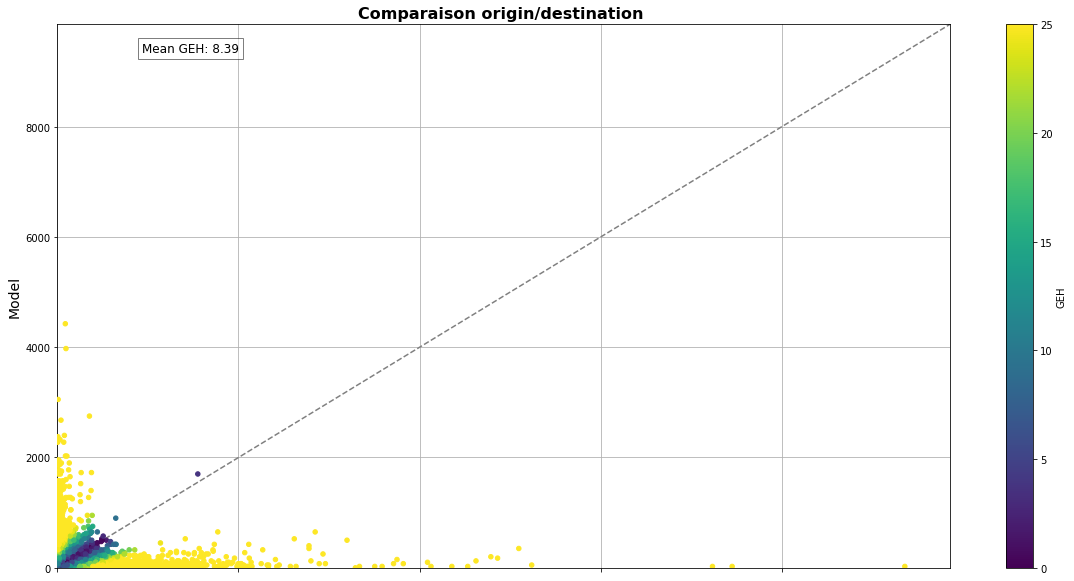

In [512]:
to_plot = comp_volumes[~ ((comp_volumes["volumes_PPAM"].isna()) |  (comp_volumes["volumes"].isna()))]
ycol= 'volumes'
xcol= 'volumes_PPAM'
to_plot['GEH'] = GEH(to_plot['volumes'], to_plot['volumes_PPAM'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[20, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes','volumes_PPAM']].max().max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylabel('Model', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison origin/destination ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()
#fig.savefig('../../outputs/plot/%s/%s/%s.png' % (scenario+'_'+period_s,zone, 'boardings_bus'), bbox_inches='tight', dpi=150)

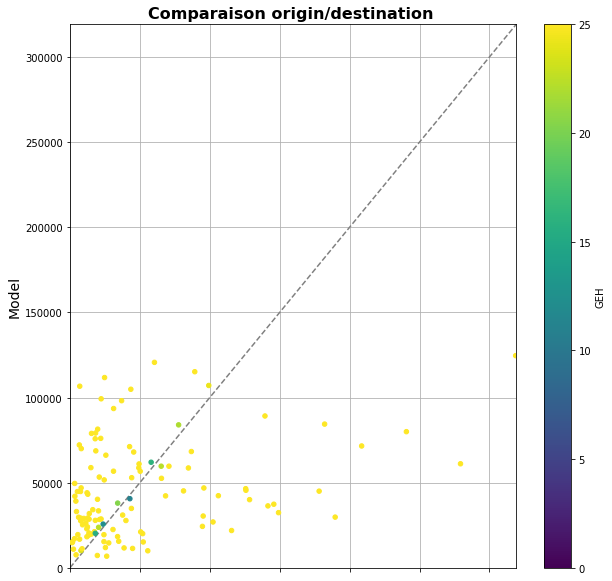

In [499]:
to_plot = comp_volumes_macro.set_index(['origin_macro', 'destination_macro'])
ycol= 'volumes'
xcol= 'volumes_PPAM'
to_plot['GEH'] = GEH(to_plot['volumes'], to_plot['volumes_PPAM'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

stats = True


t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylabel('Model', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison origin/destination ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()

# Volumes comparison - distance

In [500]:
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier

In [501]:
origins = sm.volumes['origin'].unique().tolist()
destinations = sm.volumes['destination'].unique().tolist()

distances = euclidean(sm.zones, coordinates_unit='meter', epsg=4326, origins=origins, destinations=destinations)
distances['euclidean_distance'] = (distances['euclidean_distance']/1000).apply(lambda x: round_up(x,-1))
distances = distances[['origin', 'destination', 'euclidean_distance']]


In [502]:
comp_volumes_dist= comp_volumes.merge(distances, on = ['origin','destination'] , how= 'left' )
comp_volumes_dist = comp_volumes_dist.groupby('euclidean_distance')['volumes_PPAM', 'volumes'].sum()

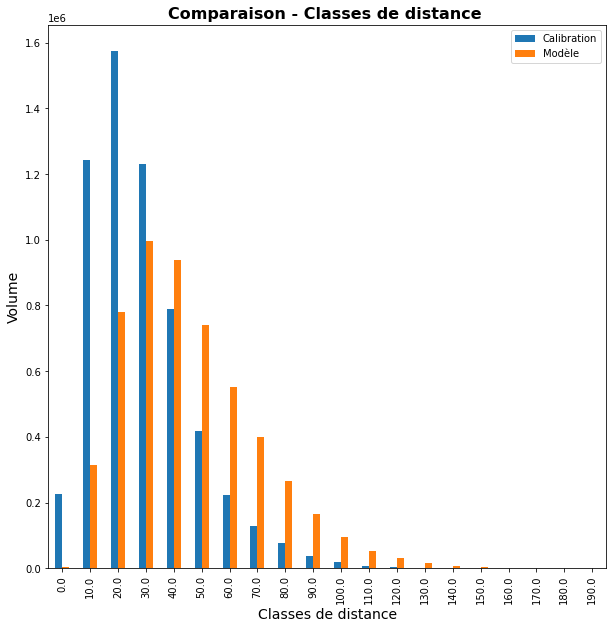

In [503]:
comp_volumes_dist.plot( kind = 'bar', figsize=[10, 10])
plt.ylabel('Volume', fontsize=14)
plt.xlabel('Classes de distance', fontsize=14)
plt.title('Comparaison - Classes de distance ', loc='center', fontsize=16, fontweight="bold")
plt.legend(['Calibration', 'Modèle'])
fig = ax.get_figure()


# LOGIT Calibration

In [504]:
sm = stepmodel.read_zippedpickles(model_folder + 'logit_assignment')


zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 43/43 [00:08<00:00,  4.80it/s]


 ## Part modale

In [505]:
sm.los.loc[sm.los['route_type'] == 'car']['volume'].sum(), sm.los.loc[sm.los['route_type'] != 'car']['volume'].sum()

(5358717.943722128, 1312.107351690082)

In [506]:
los = sm.los[['origin', 'destination','route_type', 'volume']]
los = los.groupby(['origin', 'route_type']).sum()
los = los.unstack('route_type')['volume']
los.columns = los.columns.values
los['volume'] = los.sum(axis=1)
los['pt'] = los[list(set(los.columns) - {'car', 'walk', 'volume'})].sum(axis=1)

los['part_car'] = los['car']/los[['car', 'pt', 'walk']].sum(axis=1) 
los['part_pt'] = los['pt']/los[['car', 'pt', 'walk']].sum(axis=1) 
los['part_walk'] = los['walk']/los[['car', 'pt', 'walk']].sum(axis=1) 

part_model = groupby_weighted_average(los, 'origin', ['part_car', 'part_pt', 'part_walk'], 'volume')

In [507]:
zones_part_modale = block_name_tract.merge(zones[['index', 'NAME', 'ratio']], on=  'NAME', how = 'left')
zones_part_modale['part_car'] = zones_part_modale['car']/zones_part_modale[['car', 'pt', 'walk']].sum(axis=1) 
zones_part_modale['part_pt'] = zones_part_modale['pt']/zones_part_modale[['car', 'pt', 'walk']].sum(axis=1) 
zones_part_modale['part_walk'] = zones_part_modale['walk']/zones_part_modale[['car', 'pt', 'walk']].sum(axis=1) 

part_calibration = groupby_weighted_average(zones_part_modale, 'index', ['part_car', 'part_pt', 'part_walk','PPAM'], 'PPAM')

<Axes: >

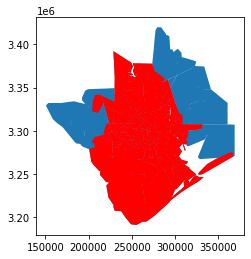

In [508]:
# il manque des zones
ax = sm.zones.plot()
sm.zones.loc[part_calibration.index].plot(color ="r" ,ax =ax)

In [509]:
comp_part_modale = part_calibration.merge(part_model, left_index=True, right_index=True, suffixes=('_calibration', '_model'))
comp_part_modale["origin_macro"] = comp_part_modale.index.to_series().apply(lambda x : dico_macro_zones[x])
comp_part_modale_macro = groupby_weighted_average(comp_part_modale, 'origin_macro', ['part_car_calibration', 'part_pt_calibration', 'part_walk_calibration','part_car_model', 'part_pt_model', 'part_walk_model'], 'PPAM')
#

In [510]:
colors = ["#D22328", "#559BB4", "#DC9100" , "#91A564","#8C4B7D", "#A08C69","#647D6E", "#5A7382", "#64411E", "#A00037", "#643C5A"]  

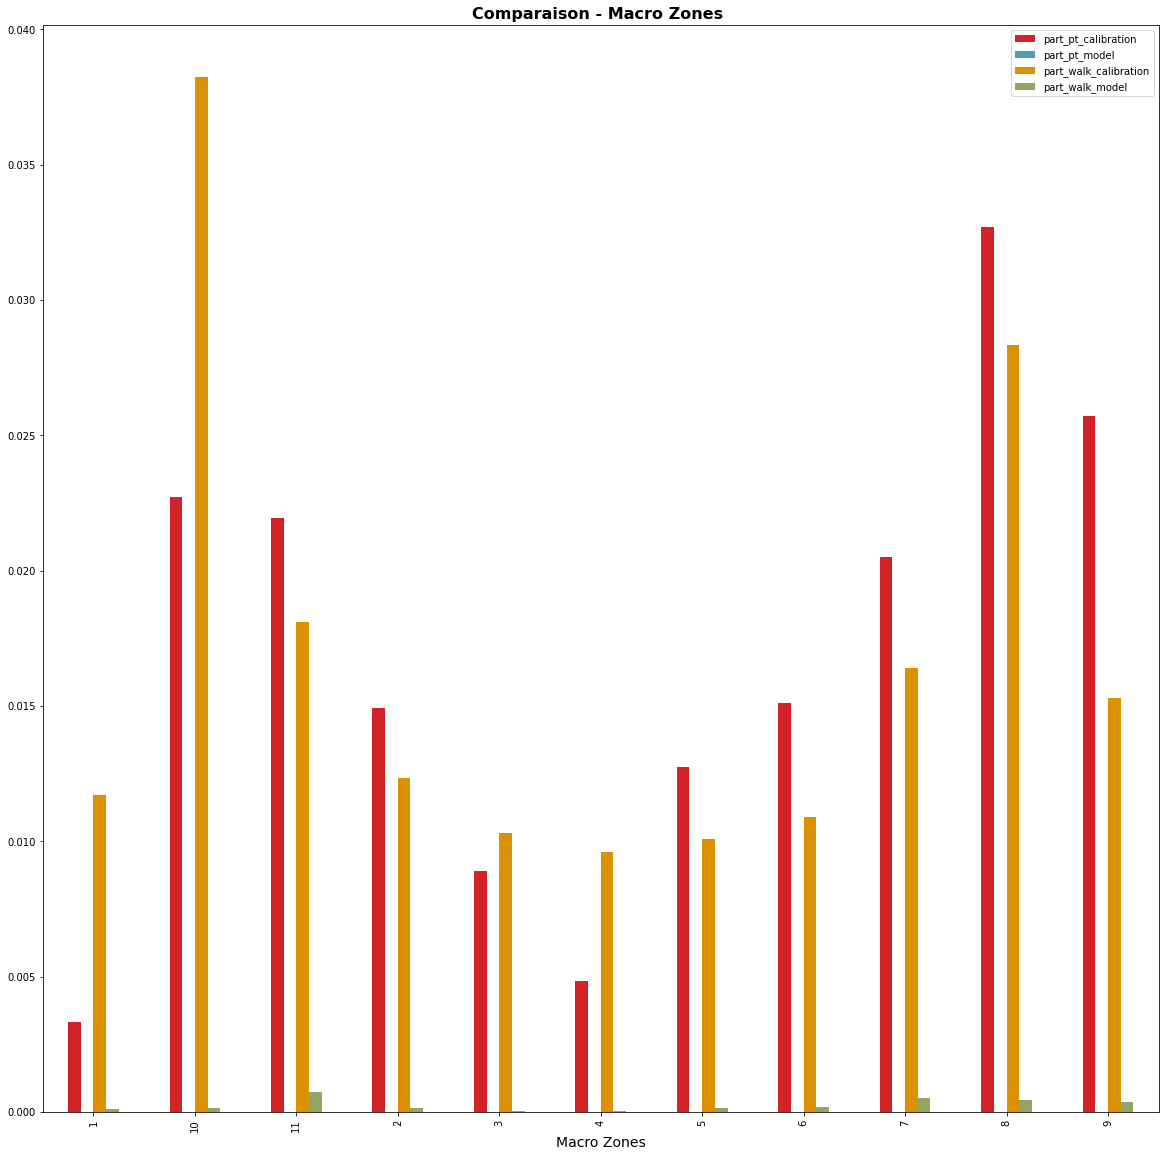

In [511]:
comp_part_modale_macro[['part_pt_calibration','part_pt_model','part_walk_calibration','part_walk_model']].plot( kind = 'bar', figsize=[20, 20],color = colors)
plt.xlabel('Macro Zones', fontsize=14)
plt.title('Comparaison - Macro Zones ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()


## Mode structurant 